Notebook purpose

- Sense-check and explore calculated account balances

In [187]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import s3fs

sys.path.append('/Users/fgu/dev/projects/entropy')
from entropy import config
from entropy.helpers import aws
from entropy.helpers import helpers
import entropy.data.cleaners as cl
import entropy.data.creators as cr
import entropy.figures.figures as figs

sns.set_style('whitegrid')
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)
pd.set_option('max_colwidth', None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

fs = s3fs.S3FileSystem(profile='3di')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
SAMPLE = 'X77'
fp = f'~/tmp/entropy/entropy_{SAMPLE}.parquet'
fp = 's3://3di-project-entropy/entropy_XX7.parquet'

df = aws.read_parquet(fp)
print('Rows: {:,.0f}\nUsers: {}'.format(df.shape[0], df.user_id.nunique()))

Rows: 6,791,894
Users: 2357


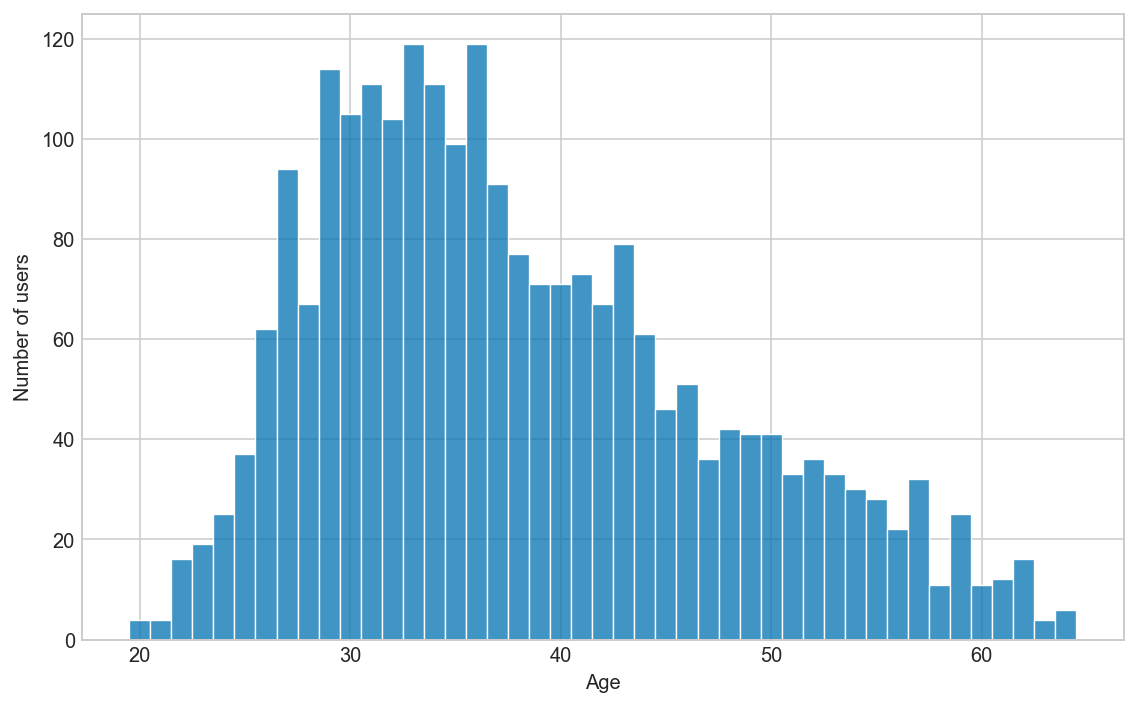

In [45]:
figs.user_age_hist(df, write=False)

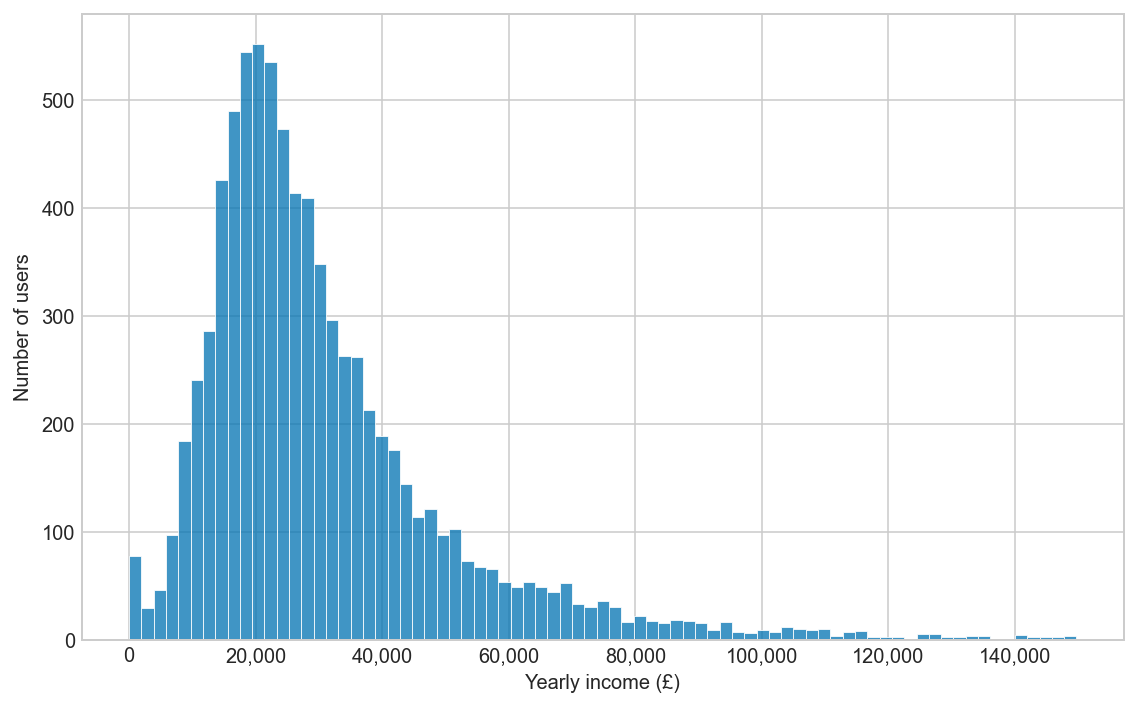

In [51]:
figs.user_income_hist(df, write=False)

In [215]:
def _get_regions_lookup_table():
    """Returns region lookup table."""
    fs = s3fs.S3FileSystem(profile=config.AWS_PROFILE)
    filename = 'region_lookup_table.parquet'
    filepath = os.path.join(config.AWS_BUCKET, filename)
    if fs.exists(filepath):
        return aws.read_parquet(filepath)
    else:
        return helpers.make_region_lookup_table()
    
def make_data(df):
    region = _get_regions_lookup_table()
    user_pcsector = (df.groupby('user_id')
                 .user_postcode.first()
                 .astype('object')
                 .str.replace(' ', '')
                 .str.upper()
                 .rename('pcsector')
                 .reset_index()
                )
    df = user_pcsector.merge(region, how='left', on='pcsector', validate='m:1')
    return df.region.value_counts(ascending=True)
    
    
data = make_data(df)

user_region_distr.png written.


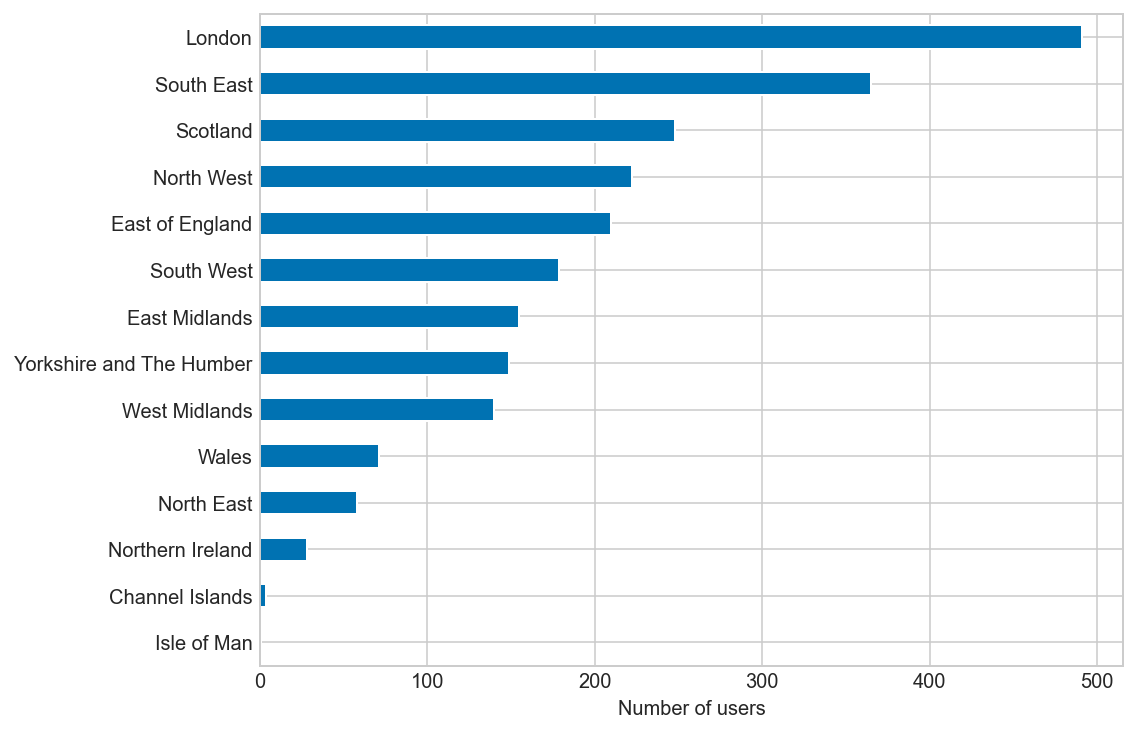

In [218]:
figs.user_region_distr(df)

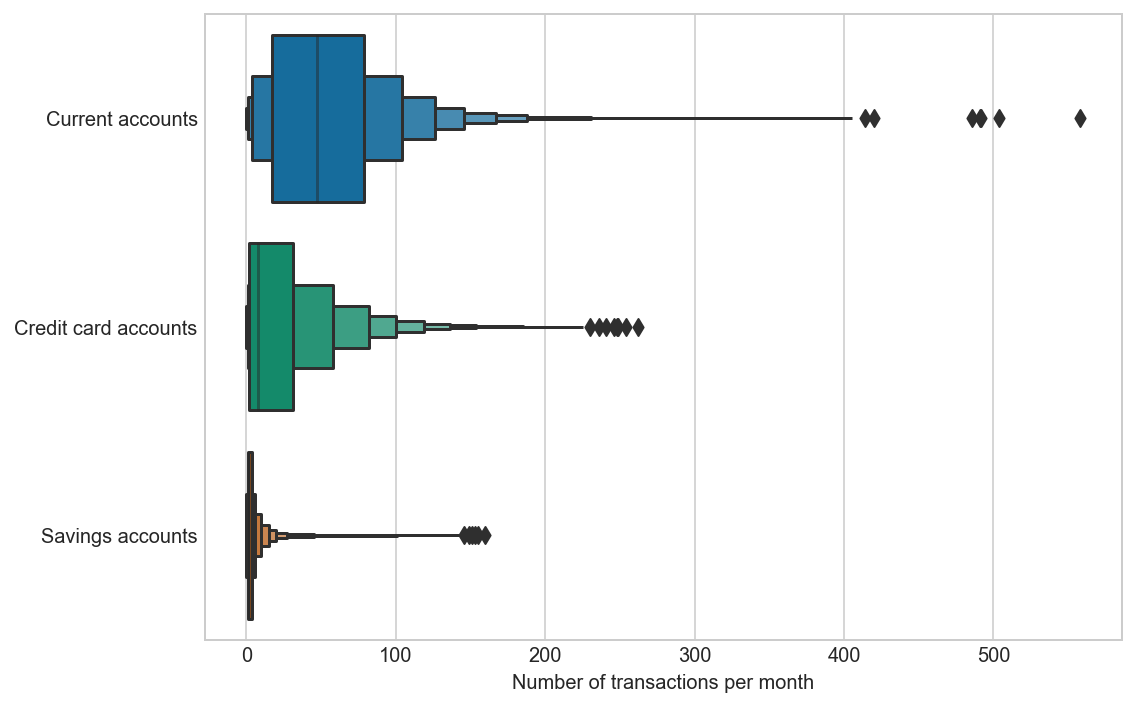

In [54]:
figs.num_txns_by_account_type(df, write=False)

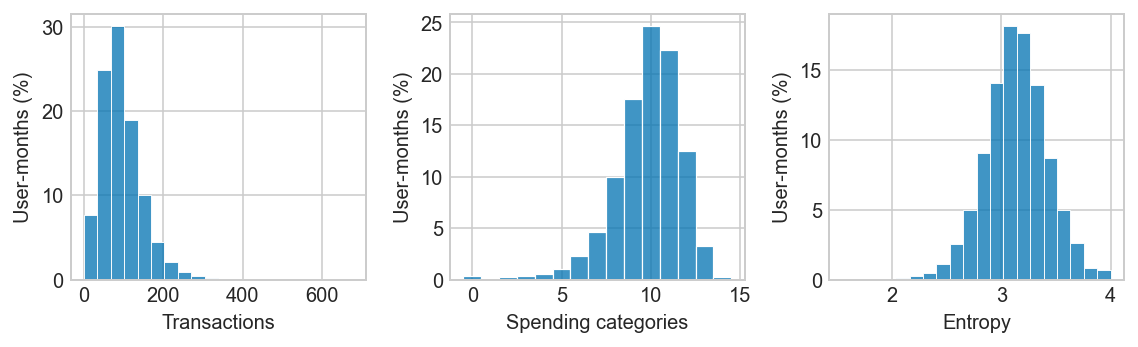

In [39]:
figs.txns_categories_entropy_hists(df, write=False)